In [1]:
from graphviz import Digraph 

In [2]:
import numpy as np 
import math

In [3]:
# import torch

In [4]:
# torch.cuda.is_available()

In [5]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [91]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data 
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op 
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"

    def __add__(self, other): 
        # self, other 这两个子结点, 产生父结点 out
        other = other if isinstance(other, Value) else Value(other, label='Cons')
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out 

    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other, label='Cons')
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): 
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 

        out._backward = _backward
        return out 
        
    # 这里是如何检测到并且实施的呢
    def __rmul__(self, other): 
        return self * other

    def __radd__(self, other): 
        return self + other

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward(): 
            # 小小的差别竟然报错:  'int' object has no attribute 'data'
            # self.grad += other.data * self.data**(other-1) * out.grad 
            self.grad += other * self.data**(other-1) * out.grad

        out._backward = _backward
        return out 

    def __truediv__(self, other): 
        return self * other**-1

    def __neg__(self):  
        return self * -1 

    def __sub__(self, other):  
        return self + (-other)
        
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward(): 
            self.grad += (1 - t**2) * out.grad 
        
        out._backward = _backward
        return out 

    def exp(self): 
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward(): 
            # self.grad += math.exp(x) * out.grad 
            self.grad += out.data * out.grad 

        out._backward = _backward
        return out 

    def backward(self): 
        topo = [] 
        visited = set()

        def build_topo(v): 
            if v not in visited: 
                visited.add(v) 
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0 

        for node in reversed(topo): 
            node._backward()

In [76]:
a = Value(2.0, label='a')
a ** 2

Value(data=4.0)

In [77]:
a.__pow__(2)

Value(data=4.0)

In [93]:
# 2**a # 这个不能简单的__rpow__吧, 导数不是一回事

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[50], line 1
----> 1 2**a

TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'Value'
``` 

In [54]:
b = 1 + a; b.label='b'
b 

Value(data=3.0)

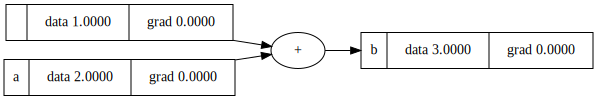

In [55]:
draw_dot(b)

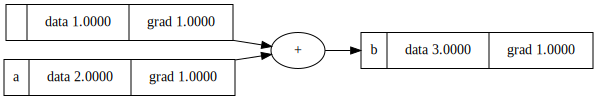

In [56]:
b.backward()
draw_dot(b)

In [43]:
# 如何实现除法
# a = 3; b = 2 
# a / b 
# a * (1/b)
# a * (b**-1) # 都用乘法表示

1.5

In [84]:
a = Value(4.0, label='a')
b = Value(2, label='b')

c = b / a; c.label ='c'
c 

Value(data=0.5)

In [80]:
# 实现减法
# a - b
# a + (-b)  # 这里是负号不是减号, 通过__neg__实现
# a + (-1 * b) # 这样, 只有加法和乘法, 

In [85]:
a = Value(4.0, label='a')
b = Value(2, label='b')

In [86]:
b - a 

Value(data=-2.0)

In [7]:
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
o = n.tanh(); o.label='o'

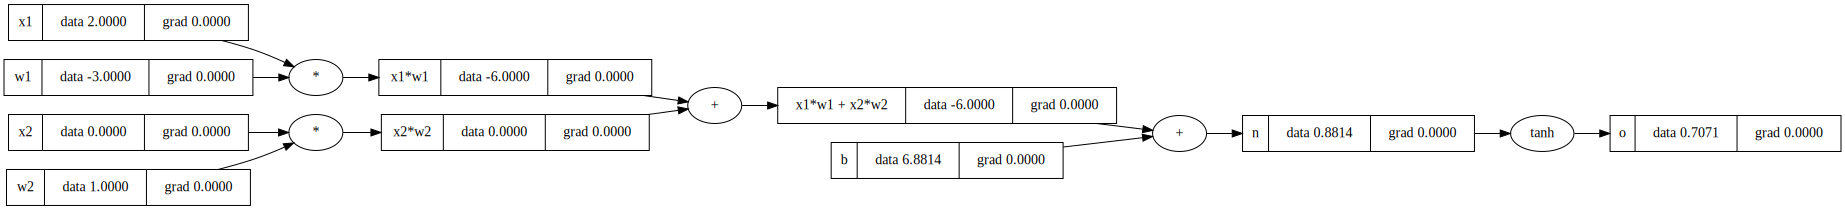

In [8]:
draw_dot(o)

In [9]:
o.backward()

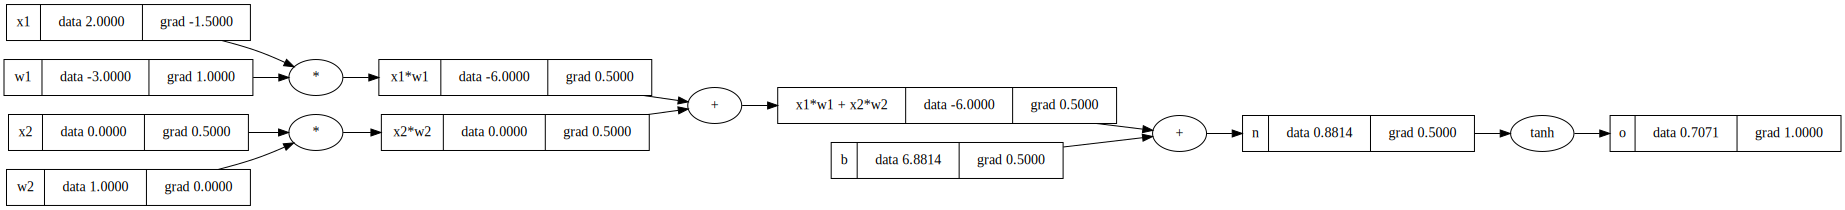

In [10]:
draw_dot(o)

### 处理特殊情况

In [28]:
x = Value(3.0); x.label = 'x'
y = Value(2.);  y.label = 'y'

In [29]:
x 

Value(data=3.0)

In [30]:
x.__add__(y)

Value(data=5.0)

In [31]:
# 通过将 2 即(other)包装为一个Value来解决这个问题
x.__add__(2)

Value(data=5.0)

```
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[27], line 1
----> 1 x.__add__(2)

Cell In[15], line 15, in Value.__add__(self, other)
     13 def __add__(self, other): 
     14     # self, other 这两个子结点, 产生父结点 out
---> 15     out = Value(self.data + other.data, (self, other), '+')
     17     def _backward(): 
     18         self.grad += 1.0 * out.grad

AttributeError: 'int' object has no attribute 'data'
```

In [32]:
2 + x 

Value(data=5.0)

In [33]:
# 同理
x * 2

Value(data=6.0)

In [34]:
# 等价于
x.__mul__(2)

Value(data=6.0)

In [35]:
2 * x 
# 但是没方法
# 2.__mul__(x)

Value(data=6.0)

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[35], line 1
----> 1 2 * x 

TypeError: unsupported operand type(s) for *: 'int' and 'Value'
``` 

In [38]:
### exp part 
a = Value(2.0, label='a')
a.exp()

Value(data=7.38905609893065)

In [39]:
a.backward()

In [40]:
a.grad

1.0

## 这里最聪明的一点在于用乘法和加法来实现了除法和减法, 这样就不需要重写他们的梯度函数!!! 

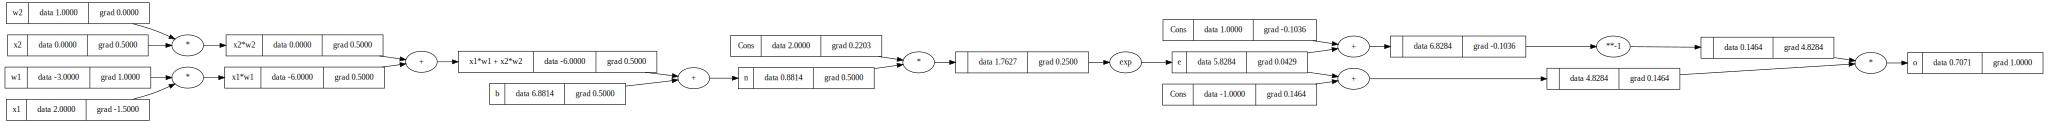

In [92]:
# 实现了除法和减法之后,   将tanh展开
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
# --------
# o = n.tanh()
# -------
e = (2 * n).exp(); e.label='e'

o = (e - 1) / (e + 1)
o.label='o'
o.backward()
draw_dot(o)

In [94]:
import torch

In [106]:
# python 浮点数默认64位精度 

In [97]:
# 而pytorch默认 32位精度, 所以为了保持一直, 这里转为了64位
# 由于是叶节点, pytorch默认为不需要梯度, 所以需要指定为true

x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True

In [98]:
n = x1*w1 + x2*w2 + b 

In [99]:
o = torch.tanh(n)

In [100]:
# item 是去掉张量的包装, 解包为元素
print(o.data.item())

0.7071066904050358


In [101]:
o.backward()

In [102]:
print('---------')
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item()) 
print("w1", w1.grad.item())

---------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [107]:
x1 

tensor([2.], dtype=torch.float64, requires_grad=True)

In [109]:
x1.data

tensor([2.], dtype=torch.float64)

In [108]:
x1.data.item()

2.0